In [ ]:
import os
import re
import pandas as pd
import numpy as np
import json
import torch
from PIL import Image
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


In [6]:
files_paths = "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy/"
with open(files_paths + "/matching_uids.json", 'r') as f:
    matching_uids = json.load(f)


In [7]:
len(matching_uids)

31692

In [2]:
files_paths = "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy/"
with open(files_paths + "gpt4o_response_list.json", 'r') as f:
    gpt4o_response_list = json.load(f)


In [3]:
gpt4o_response_list[0:2]

['Modality: Clinical Photograph  \nAnatomy: Eyes',
 'Modality: Ultrasound  \nAnatomy: Eyes']

In [4]:
len(gpt4o_response_list)

131155

In [5]:
gpt4o_dict = {idx: response for idx, response in enumerate(gpt4o_response_list) if not "Other/None/Unknown" in response}

In [6]:
len(gpt4o_dict)

81617

In [2]:
filtered_csv_path = r'/cs/labs/tomhope/dhtandguy21/envs/pmc_project/21_sep_filtered_data.csv'

In [3]:
filtered_df = pd.read_csv(filtered_csv_path)

In [4]:
len(filtered_df)

131155

In [10]:
filtered_df_path = "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/pythonFilesGuy/filtered_df.csv"
filtered_df = pd.read_csv(filtered_df_path)
filtered_df.head(3)

,image_path,caption_path,patient_uid,pmc_id,article_path,unique_articles_sim_patients,caption_text,caption_id
0,PMC8167975/8167975_1/8167975_1_1.jpg,PMC8167975/8167975_1/8167975_1_1.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],"Fundus photograph showed a yellowish white, pe...",8167975_1_1
1,PMC8167975/8167975_1/8167975_1_2.jpg,PMC8167975/8167975_1/8167975_1_2.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],B-scan demonstrated focal subretinal calcifica...,8167975_1_2
2,PMC8167975/8167975_1/8167975_1_3.jpg,PMC8167975/8167975_1/8167975_1_3.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],CT demonstrated a hyperdense choroidal plaque ...,8167975_1_3


In [11]:
filtered_df.loc[list(gpt4o_dict.keys()), "gpt4o_response"] = list(gpt4o_dict.values())

In [12]:
filtered_df.head(3)

,image_path,caption_path,patient_uid,pmc_id,article_path,unique_articles_sim_patients,caption_text,caption_id,gpt4o_response
0,PMC8167975/8167975_1/8167975_1_1.jpg,PMC8167975/8167975_1/8167975_1_1.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],"Fundus photograph showed a yellowish white, pe...",8167975_1_1,Modality: Clinical Photograph \nAnatomy: Eyes
1,PMC8167975/8167975_1/8167975_1_2.jpg,PMC8167975/8167975_1/8167975_1_2.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],B-scan demonstrated focal subretinal calcifica...,8167975_1_2,Modality: Ultrasound \nAnatomy: Eyes
2,PMC8167975/8167975_1/8167975_1_3.jpg,PMC8167975/8167975_1/8167975_1_3.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],CT demonstrated a hyperdense choroidal plaque ...,8167975_1_3,Modality: CT \nAnatomy: Eyes


In [13]:
def normalize(text):
    return re.sub(r'\s+', ' ', text.strip())
    
filtered_df["gpt4o_response"] = filtered_df["gpt4o_response"].apply(normalize)

In [14]:
filtered_df.head(3)

,image_path,caption_path,patient_uid,pmc_id,article_path,unique_articles_sim_patients,caption_text,caption_id,gpt4o_response
0,PMC8167975/8167975_1/8167975_1_1.jpg,PMC8167975/8167975_1/8167975_1_1.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],"Fundus photograph showed a yellowish white, pe...",8167975_1_1,Modality: Clinical Photograph Anatomy: Eyes
1,PMC8167975/8167975_1/8167975_1_2.jpg,PMC8167975/8167975_1/8167975_1_2.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],B-scan demonstrated focal subretinal calcifica...,8167975_1_2,Modality: Ultrasound Anatomy: Eyes
2,PMC8167975/8167975_1/8167975_1_3.jpg,PMC8167975/8167975_1/8167975_1_3.txt,8167975-1,8167975,https://ncbi.nlm.nih.gov/pmc/articles/PMC8167975,['5563556-1'],CT demonstrated a hyperdense choroidal plaque ...,8167975_1_3,Modality: CT Anatomy: Eyes


In [15]:
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display  # For displaying images in Jupyter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from concurrent.futures import ThreadPoolExecutor

In [16]:
import open_clip

In [17]:
from open_clip import create_model_from_pretrained, get_tokenizer # For BiomedCLIP model
from transformers import AutoTokenizer, AutoModel # For BioLinkBERT model

In [18]:
# Uploading a csv file to a pandas DataFrame
def upload_csv(file_path):
    df = pd.read_csv(file_path)
    return df

def read_caption(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""

def read_captions_parallel(paths, max_workers=8):
    captions = [None] * len(paths)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_index = {executor.submit(read_caption, path): idx for idx, path in enumerate(paths)}
        for future in future_to_index:
            idx = future_to_index[future]
            try:
                captions[idx] = future.result()
            except Exception as e:
                print(f"Error reading caption at index {idx}: {e}")
                captions[idx] = ""
    return captions

In [19]:
# Loading the lists from a json file
lists_path = "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy/"

with open(lists_path + 'matching_uids.json', 'r') as f:
    matching_uids = json.load(f)

with open(lists_path + 'pairs_text_list.json', 'r') as g:
    pairs_text_list = json.load(g)

with open(lists_path + 'pairs_image_list.json', 'r') as h:
    pairs_image_list = json.load(h)

In [20]:
def subgroup_pairs_imgs_txt(begin, end):
    return pairs_text_list[begin:end], pairs_image_list[begin:end]

In [21]:
len(pairs_image_list)

31692

In [22]:
txt_subgroup_pairs, img_subgroup_pairs = subgroup_pairs_imgs_txt(0, 5)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
# This function is designated to compute textual embeddings based on a pre-chosen model
def compute_textual_embeddings(captions_paths, text_model_type):
    captions = read_captions_parallel(captions_paths)
    
    if text_model_type == 'biomedclip':
        tokens = tokenizer(captions).to(device)
        # Disable gradient computation to optimize memory usage
        with torch.no_grad():
            text_ftrs = model.encode_text(tokens)
                
    elif text_model_type == 'biolinkbert':
        inputs = tokenizer(
            captions,
            max_length=512,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            model_output = model(**inputs)
            # Obtain the token embeddings from the last hidden state
            token_embeddings = model_output.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]
            # Create an attention mask
            attention_mask = inputs['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
            # Perform mean pooling
            sum_embeddings = torch.sum(token_embeddings * attention_mask, dim=1)
            sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
            text_ftrs = sum_embeddings / sum_mask  # Shape: [batch_size, hidden_dim]


    elif text_model_type == 'mpnet':
        with torch.no_grad():
            text_ftrs = model.encode(captions, convert_to_tensor=True, batch_size=32)
            
    else:
        raise ValueError("Invalid text_model_type. Can only accept one of the following: 'biomedclip', 'mpnet', 'biolinkbert'")

    return text_ftrs

In [25]:
# Function to compute cosine similarity matrix
def compute_cosine_similarity_matrix(embeddings_i, embeddings_j):
    # Normalize embeddings
    embeddings_i_norm = embeddings_i / embeddings_i.norm(dim=1, keepdim=True)
    embeddings_j_norm = embeddings_j / embeddings_j.norm(dim=1, keepdim=True)
    # Compute cosine similarity matrix
    similarity_matrix = torch.mm(embeddings_i_norm, embeddings_j_norm.t())
    return similarity_matrix
    
# Function to create bipartite graph
def create_bipartite_graph(similarity_matrix, nodes_i, nodes_j, threshold):

    B = nx.Graph()
    # Add all nodes with the bipartite attribute
    B.add_nodes_from(nodes_i, bipartite=0)
    B.add_nodes_from(nodes_j, bipartite=1)
    
    # Add edges with weights greater than or equal to the threshold
    for i, node_i in enumerate(nodes_i):
        for j, node_j in enumerate(nodes_j):
            weight = similarity_matrix[i, j]
            if weight >= threshold:
                B.add_edge(node_i, node_j, weight=weight)
    return B

def activate_text_model(text_model_type):
    # Always use BiomedCLIP for the image encoder
    biomedclip_model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
    biomedclip_model.to(device)
    biomedclip_model.eval()
    
    if text_model_type == 'biomedclip':
        # Use BiomedCLIP for both image and text encoding
        tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
        model = biomedclip_model

    elif text_model_type == 'biolinkbert':
        # Load BioLinkBERT tokenizer and model
        biolinkbert_model_name = "michiyasunaga/BioLinkBERT-base"
        tokenizer = AutoTokenizer.from_pretrained(biolinkbert_model_name)
        model = AutoModel.from_pretrained(biolinkbert_model_name).to(device)
        model.eval()


    elif text_model_type == 'mpnet':
        # Load MPNet model (doesn't need a separate tokenizer)
        model = SentenceTransformer('all-mpnet-base-v2', device=device)
        model.eval()
        tokenizer = None  # No separate tokenizer for MPNet

    else:
        raise ValueError("Invalid model_type. Can only accept one of: 'biomedclip', 'mpnet', 'biolinkbert'")

    # Return the image model (biomedclip_model), preprocess function, the selected text model, and its tokenizer
    return biomedclip_model, preprocess, model, tokenizer


In [26]:
# Function to process a patient pair
def process_patient_pair(img_pair, caption_pair, key, text_model_type):
    # Extract caption paths
    imgs_paths_i, imgs_paths_j = img_pair
    captions_paths_i, captions_paths_j = caption_pair

    # Compute textual embeddings
    text_ftrs_i = compute_textual_embeddings(captions_paths_i, text_model_type)
    text_ftrs_j = compute_textual_embeddings(captions_paths_j, text_model_type)

    # Compute similarity matrix
    sim_matrix_text = compute_cosine_similarity_matrix(text_ftrs_i, text_ftrs_j)

    # Flatten the similarity matrices and collect values
    sim_values_text = sim_matrix_text.flatten()    

    # Create node labels
    nodes_i = [f'{key}_i_{n}' for n in range(len(imgs_paths_i))]
    nodes_j = [f'{key}_j_{n}' for n in range(len(imgs_paths_j))]

    # Create node-image mappings
    node_images_i = dict(zip(nodes_i, imgs_paths_i))
    node_images_j = dict(zip(nodes_j, imgs_paths_j))

    # Create bipartite graphs with adjusted thresholds
    B_text = create_bipartite_graph(sim_matrix_text, nodes_i, nodes_j, threshold=0.80)

    # Store results in dictionaries
    similarity_matrices = {'text': sim_matrix_text}

    bipartite_graphs = {'text': B_text}

    node_images = {
        'nodes_i': node_images_i,
        'nodes_j': node_images_j
    }

    nodes = {
        'nodes_i': nodes_i,
        'nodes_j': nodes_j
    }



    return similarity_matrices, bipartite_graphs, node_images, nodes


In [27]:
text_model_type = 'biomedclip'
biomedclip_model, preprocess, model, tokenizer = activate_text_model(text_model_type)


In [28]:
# # Main code to process all pairs
# similarity_matrices_text = {}

# bipartite_graphs_text = {}

# node_images_i = {}
# node_images_j = {}
# patient_i_nodes = {}
# patient_j_nodes = {}

# # Choose 'biomedclip' OR 'biolinkbert' OR 'mpnet'
# text_model_type = 'biomedclip'
# biomedclip_model, preprocess, model, tokenizer = activate_text_model(text_model_type)


# for idx, (img_pair, caption_pair) in enumerate(zip(img_subgroup_pairs, txt_subgroup_pairs)):
#     # Create a unique key for each pair, e.g., using patient IDs or indices
#     key = f'Pair_{idx+1} ({matching_uids[idx][0]}, {matching_uids[idx][1]})'

#     # Process the patient pair
#     similarity_matrices, bipartite_graphs, node_images, nodes = process_patient_pair(img_pair, caption_pair, key, text_model_type)

#     # Store similarity matrices
#     similarity_matrices_text[key] = similarity_matrices['text']

#     # Store bipartite graphs
#     bipartite_graphs_text[key] = bipartite_graphs['text']

#     # Store node images and node labels
#     node_images_i[key] = node_images['nodes_i']
#     node_images_j[key] = node_images['nodes_j']
#     patient_i_nodes[key] = nodes['nodes_i']
#     patient_j_nodes[key] = nodes['nodes_j']


In [29]:
# import pickle
# with open("similarity_matrices_text.pkl", "wb") as a:
#     pickle.dump(similarity_matrices_text, a)

# with open("bipartite_graphs_text.pkl", "wb") as b:
#     pickle.dump(bipartite_graphs_text, b)

# with open("node_images_i.pkl", "wb") as c:
#     pickle.dump(node_images_i, c)

# with open("node_images_j.pkl", "wb") as d:
#     pickle.dump(node_images_j, d)

# with open("patient_i_nodes.pkl", "wb") as e:
#     pickle.dump(patient_i_nodes, e)

# with open("patient_j_nodes.pkl", "wb") as k:
#     pickle.dump(patient_j_nodes, k)


In [30]:
import pickle

with open("/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy/dict_of_text_sim_matrices.pkl", "rb") as b:
    similarity_matrices_text = pickle.load(b)



In [31]:
# # Updated manual bipartite layout with normalization (to prevent large coordinate values)
# def manual_bipartite_layout(B, nodes_i, nodes_j, graph_type):
#     pos = {}
#     total_nodes = max(len(nodes_i), len(nodes_j))

#     if graph_type == 'updown':
#         # Assign positions along the x-axis from 0 to 1
#         x_positions_i = np.linspace(0, 1, len(nodes_i))
#         x_positions_j = np.linspace(0, 1, len(nodes_j))

#         # Position nodes_i at y=1
#         for x, node in zip(x_positions_i, sorted(nodes_i)):
#             pos[node] = np.array([x, 1])

#         # Position nodes_j at y=0
#         for x, node in zip(x_positions_j, sorted(nodes_j)):
#             pos[node] = np.array([x, 0])

#     elif graph_type == 'leftright':
#         # Assign positions along the y-axis from 0 to 1
#         y_positions_i = np.linspace(0, 1, len(nodes_i))
#         y_positions_j = np.linspace(0, 1, len(nodes_j))
        
#         # Position nodes_i on the left (x=0)
#         for y, node in zip(y_positions_i, sorted(nodes_i)):
#             pos[node] = np.array([0, y])
            
#         # Position nodes_j on the right (x=1)
#         for y, node in zip(y_positions_j, sorted(nodes_j)):
#             pos[node] = np.array([1, y])

#     else:
#         raise ValueError("Invalid graph_type. Can only accept one of the following: 'updown', 'leftright'")     
    
#     return pos


# # Visualizaing a bipartite graph with images at each node
# def visualize_bipartite_graph_with_images(B, nodes_i, nodes_j, node_images_i, node_images_j, title='Bipartite Graph with Images'):
#     # Generate positions using the updated manual layout
#     pos = manual_bipartite_layout(B, nodes_i, nodes_j, 'leftright')

#     # Proceed with plotting
#     plt.figure(figsize=(12, 8), dpi=150)
#     ax = plt.gca()
#     plt.title(title)
    
#     # Draw edges if any
#     if B.number_of_edges() > 0:
#         nx.draw_networkx_edges(B, pos, edge_color='gray', alpha=0.5)
    
#     # Function to add images to nodes
#     def add_image_nodes(nodes, node_images):
#         for node in nodes:
#             if node in node_images and node in pos:
#                 try:
#                     img_path = node_images[node]
#                     # Check if the image path exists
#                     if not os.path.exists(img_path):
#                         print(f"Image file does not exist for node {node}: {img_path}")
#                         continue
#                     # Load and resize the image
#                     img = Image.open(img_path).convert('RGB')
#                     img.thumbnail((50, 50), Image.LANCZOS)
#                     img_array = np.asarray(img)

#                     # Adjust zoom to control image size on the graph
#                     imagebox = OffsetImage(img_array, zoom=0.8)
#                     ab = AnnotationBbox(imagebox, pos[node], frameon=False)
#                     ax.add_artist(ab)
#                 except Exception as e:
#                     print(f"Error loading image for node {node}: {e}")
#             else:
#                 # Draw a placeholder if the image is missing
#                 if node in pos:
#                     print(f"No image for node {node}")
#                     nx.draw_networkx_nodes(B, pos, nodelist=[node], node_color='red', node_size=100)
    
#     # Add images for nodes_i and nodes_j
#     add_image_nodes(nodes_i, node_images_i)
#     add_image_nodes(nodes_j, node_images_j)
    
#     # Set fixed axis limits to prevent shrinking
#     ax.set_xlim(-0.1, 1.1)
#     ax.set_ylim(-0.1, 1.1)
    
#     plt.axis('off')
#     plt.show()

# # Function to visualize embeddings
# def visualize_embedding_type(embedding_type, embedding_data, node_images_i_dict, node_images_j_dict, patient_i_nodes_dict, patient_j_nodes_dict):
#     """
#     Visualizes bipartite graphs for a specified embedding type.
#     """
#     if embedding_type not in embedding_data:
#         print(f"Invalid embedding type '{embedding_type}'. Please choose 'text'.")
#         return

#     print(f"\nVisualizing graphs for {embedding_type} embeddings")
#     similarity_matrices = embedding_data[embedding_type]['similarity_matrices']
#     bipartite_graphs = embedding_data[embedding_type]['bipartite_graphs']

#     # Iterate over the pairs to visualize
#     for idx, key in enumerate(similarity_matrices.keys()):
#         print(f"\nVisualizing bipartite graph for {key} ({embedding_type} embeddings)")

#         # Retrieve the bipartite graph and node images
#         B = bipartite_graphs[key]
#         node_images_i = node_images_i_dict[key]
#         node_images_j = node_images_j_dict[key]
#         nodes_i = patient_i_nodes_dict[key]
#         nodes_j = patient_j_nodes_dict[key]

#         # Visualize the bipartite graph with images
#         title = f"{embedding_type.capitalize()} Bipartite Graph for {key} ({text_model_type})"

#         visualize_bipartite_graph_with_images(
#             B,
#             nodes_i,
#             nodes_j,
#             node_images_i,
#             node_images_j,
#             title = title
#         )

# # Prepare embedding data
# embedding_data = {
#     'text': {
#         'similarity_matrices': similarity_matrices_text,
#         'bipartite_graphs': bipartite_graphs_text,
#     }
# }

# # Call the visualization function for the desired embedding type
# desired_embedding_type = 'text'  # Choose 'text', 'visual', or 'concat'
# visualize_embedding_type(desired_embedding_type, embedding_data, node_images_i, node_images_j, patient_i_nodes, patient_j_nodes)


In [32]:
len(similarity_matrices_text)

31692

In [33]:
sim_mat_list = list(similarity_matrices_text.values())

In [34]:
sim_mat_list[0].dtype

torch.float32

In [35]:
pair_mat_list = list(similarity_matrices_text.keys())

In [36]:
pair_mat_list[3]

'Pair_4 (3358935-1, 3853602-1)'

In [37]:
filtered_df["gpt4o_response"].head(5)

0          Modality: Clinical Photograph Anatomy: Eyes
1                   Modality: Ultrasound Anatomy: Eyes
2                           Modality: CT Anatomy: Eyes
3    Modality: Optical coherence tomography (OCT) A...
4    Modality: Optical coherence tomography (OCT) A...
Name: gpt4o_response, dtype: object

In [38]:
def sim_gpt_responses_within_pair(uid_pair):
    first_uid, second_uid = uid_pair
    first_uid_responses = filtered_df[filtered_df["patient_uid"] == first_uid]["gpt4o_response"].to_list()
    second_uid_responses = filtered_df[filtered_df["patient_uid"] == second_uid]["gpt4o_response"].to_list()

    mat = np.zeros((len(first_uid_responses), len(second_uid_responses)))
    for i, first_res in enumerate(first_uid_responses):
        for j, second_res in enumerate(second_uid_responses):
            if first_res == second_res and first_res != "nan":
                mat[i][j] = 1

    return torch.tensor(mat, device=0)

In [39]:
# gpt_responses_mat_list = [sim_gpt_responses_within_pair(uid_pair) for uid_pair in matching_uids]

In [42]:
import pickle
with open("/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy/gpt4o_zero_one_mat_list.pkl", "rb") as b:
    gpt_responses_mat_list = pickle.load(b)


In [ ]:
gpt_responses_mat_list[0:3]

[tensor([[0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.]], device='cuda:0', dtype=torch.float64),
 tensor([[1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.]], device='cuda:0', dtype=torch.float64),
 tensor([[1., 0., 0.],
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]], device='cuda:0', dtype=torch.float64)]

In [ ]:
matching_uids[99]

['5658322-1', '6156021-1']

In [ ]:
gpt_responses_mat_list[99]

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.]], device='cuda:0', dtype=torch.float64)

In [ ]:
sim_mat_list[99]

tensor([[0.7272, 0.5293, 0.4199],
        [0.7433, 0.6362, 0.4821],
        [0.8179, 0.5512, 0.5409],
        [0.5719, 0.5454, 0.6817],
        [0.4786, 0.4128, 0.3860],
        [0.6066, 0.6613, 0.6397]], device='cuda:0')

In [ ]:
# The f1-score best model was set to > 0.87
# The higher pos was set to 0.9

In [43]:
def positive_caption_pairs(gpt_responses_mat, sim_mat):

    # A matrix (within the same pair) of 0's for unidentical gpt responses
    # and similarity scores for identical gpt responses
    reponse_sim_combined_mat = gpt_responses_mat * sim_mat

    # Get the indices of non-0's in a coordinates format:
    # ( [nonzero_row_index_1, nonzero_row_index_2, ...], [nonzero_col_index_1, nonzero_col_index_2, ...] )
    nonzero_indices = reponse_sim_combined_mat.nonzero(as_tuple=True)

    # Extracting the nonzero values in the relevant coordinates in the format:
    # [a,  b,  c, ...]
    nonzero_values = reponse_sim_combined_mat[nonzero_indices]

    # Extracting the coordinates of the similarity scores that exceed 0.87
    condition = nonzero_values > 0.90
    exceed_threshold_indices = tuple([idx[condition] for idx in nonzero_indices])
    
    return exceed_threshold_indices

In [44]:
positive_pairs_dict = {str(uid_pair): positive_caption_pairs(gpt_responses_mat_list[idx], sim_mat_list[idx]) for idx, uid_pair in enumerate(matching_uids)}

In [45]:
len(positive_pairs_dict)

31692

In [46]:
positive_pairs_dict

{"['8167975-1', '5563556-1']": (tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 "['4647049-1', '5654233-1']": (tensor([5], device='cuda:0'),
  tensor([1], device='cuda:0')),
 "['4647049-1', '4142379-1']": (tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 "['3358935-1', '3853602-1']": (tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 "['2629956-1', '4709607-1']": (tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 "['7732735-1', '4114596-1']": (tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 "['7732735-1', '8101558-1']": (tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 "['7732735-1', '4114622-1']": (tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=tor

In [47]:
list(positive_pairs_dict.keys())[1:2]

["['4647049-1', '5654233-1']"]

In [48]:
list(positive_pairs_dict.values())[1:2]

[(tensor([5], device='cuda:0'), tensor([1], device='cuda:0'))]

In [49]:
positive_pairs_dict["['8167975-1', '5563556-1']"]

(tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64))

In [50]:
len(positive_pairs_dict)

31692

In [51]:
gpt_responses_mat_list[1]

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], device='cuda:0', dtype=torch.float64)

In [52]:
sim_mat_list[1]

tensor([[0.7644, 0.8402],
        [0.6677, 0.7579],
        [0.6625, 0.7459],
        [0.6660, 0.7730],
        [0.6966, 0.8057],
        [0.7431, 0.9142]], device='cuda:0')

In [53]:
filtered_positive_pairs_including_indices = [(idx, pair) for idx, pair in enumerate(positive_pairs_dict.values()) if all(tensor.numel() > 0 for tensor in pair)]

In [54]:
filtered_positive_pairs_including_indices[0:3]

[(1, (tensor([5], device='cuda:0'), tensor([1], device='cuda:0'))),
 (70, (tensor([1], device='cuda:0'), tensor([4], device='cuda:0'))),
 (103, (tensor([2], device='cuda:0'), tensor([1], device='cuda:0')))]

In [55]:
len(filtered_positive_pairs_including_indices)

1056

In [56]:
filtered_positive_pairs = [pair for pair in positive_pairs_dict.values() if all(tensor.numel() > 0 for tensor in pair)]

In [57]:
filtered_positive_pairs[0:1]

[(tensor([5], device='cuda:0'), tensor([1], device='cuda:0'))]

In [58]:
filtered_positive_keys = [pair_mat_list[idx_pos_pair[0]] for idx_pos_pair in filtered_positive_pairs_including_indices]

In [59]:
filtered_positive_keys[0:3]

['Pair_2 (4647049-1, 5654233-1)',
 'Pair_71 (5471783-1, 3640977-1)',
 'Pair_104 (4719281-1, 4719241-1)']

In [60]:
list(positive_pairs_dict.values())[0:3]

[(tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64)),
 (tensor([5], device='cuda:0'), tensor([1], device='cuda:0')),
 (tensor([], device='cuda:0', dtype=torch.int64),
  tensor([], device='cuda:0', dtype=torch.int64))]

In [61]:
filtered_positive_keys[0:10]

['Pair_2 (4647049-1, 5654233-1)',
 'Pair_71 (5471783-1, 3640977-1)',
 'Pair_104 (4719281-1, 4719241-1)',
 'Pair_141 (5064890-1, 3851702-1)',
 'Pair_143 (8404579-1, 5290679-1)',
 'Pair_237 (3424945-1, 3125066-1)',
 'Pair_238 (3424945-1, 4211228-1)',
 'Pair_264 (6016002-1, 544880-1)',
 'Pair_282 (4147288-1, 3168270-1)',
 'Pair_447 (4387339-1, 8380088-1)']

In [62]:
len(filtered_positive_pairs)

1056

In [63]:
filtered_positive_keys[0:5]

['Pair_2 (4647049-1, 5654233-1)',
 'Pair_71 (5471783-1, 3640977-1)',
 'Pair_104 (4719281-1, 4719241-1)',
 'Pair_141 (5064890-1, 3851702-1)',
 'Pair_143 (8404579-1, 5290679-1)']

In [64]:
filtered_positive_pairs[0]

(tensor([5], device='cuda:0'), tensor([1], device='cuda:0'))

In [65]:
len(filtered_positive_pairs)

1056

In [66]:
counter = 0
for pos_pair in filtered_positive_pairs:
    for ten in pos_pair:
        counter += ten.numel()

In [67]:
counter / 2

1321.0

In [ ]:
# def negative_caption_pairs(sim_mat):

#     # Get the indices of non-0's in a coordinates format:
#     # ( [nonzero_row_index_1, nonzero_row_index_2, ...], [nonzero_col_index_1, nonzero_col_index_2, ...] )
#     nonzero_indices = sim_mat.nonzero(as_tuple=True)

#     # Extracting the nonzero values in the relevant coordinates in the format:
#     # [a,  b,  c, ...]
#     nonzero_values = sim_mat[nonzero_indices]

#     # Extracting the coordinates of the similarity scores that exceed 0.84 
#     condition = nonzero_values < 0.46
#     exceed_threshold_indices = tuple([idx[condition] for idx in nonzero_indices])
    
#     return exceed_threshold_indices

In [ ]:
# The best f1 score model was set to (nonzero_values > 0.45) & (nonzero_values < 0.7)
# For the pos > 0.9, I set the negative to (nonzero_values > 0.55) & (nonzero_values < 0.65)

In [ ]:
def negative_caption_pairs(gpt_responses_mat, sim_mat):

    # A matrix (within the same pair) of 0's for unidentical gpt responses
    # and similarity scores for identical gpt responses
    reponse_sim_combined_mat = gpt_responses_mat * sim_mat

    # Get the indices of non-0's in a coordinates format:
    # ( [nonzero_row_index_1, nonzero_row_index_2, ...], [nonzero_col_index_1, nonzero_col_index_2, ...] )
    nonzero_indices = reponse_sim_combined_mat.nonzero(as_tuple=True)

    # Extracting the nonzero values in the relevant coordinates in the format:
    # [a,  b,  c, ...]
    nonzero_values = reponse_sim_combined_mat[nonzero_indices]

    condition = (nonzero_values > 0.55) & (nonzero_values < 0.65)
    exceed_threshold_indices = tuple([idx[condition] for idx in nonzero_indices])
    
    return exceed_threshold_indices

In [ ]:
# def negative_caption_pairs(sim_mat):

#     # Get the indices of non-0's in a coordinates format:
#     # ( [nonzero_row_index_1, nonzero_row_index_2, ...], [nonzero_col_index_1, nonzero_col_index_2, ...] )
#     nonzero_indices = sim_mat.nonzero(as_tuple=True)

#     # Extracting the nonzero values in the relevant coordinates in the format:
#     # [a,  b,  c, ...]
#     nonzero_values = sim_mat[nonzero_indices]

#     # Extracting the coordinates of the similarity scores that exceed 0.84 
#     condition = ((nonzero_values > 0.405) & (nonzero_values < 0.41)) | ((nonzero_values > 0.605) & (nonzero_values < 0.615)) | ((nonzero_values > 0.685) & (nonzero_values < 0.69))
#     exceed_threshold_indices = tuple([idx[condition] for idx in nonzero_indices])
    
#     return exceed_threshold_indices

In [ ]:
negative_pairs_dict = {str(uid_pair): negative_caption_pairs(gpt_responses_mat_list[idx], sim_mat_list[idx]) for idx, uid_pair in enumerate(matching_uids)}

In [ ]:
# negative_pairs_dict = {str(uid_pair): negative_caption_pairs(sim_mat_list[idx]) for idx, uid_pair in enumerate(matching_uids)}

In [ ]:
filtered_negative_pairs_including_indices = [(idx, pair) for idx, pair in enumerate(negative_pairs_dict.values()) if all(tensor.numel() > 0 for tensor in pair)]

In [ ]:
filtered_negative_pairs = [pair for pair in negative_pairs_dict.values() if all(tensor.numel() > 0 for tensor in pair)]

In [ ]:
filtered_negative_keys = [pair_mat_list[idx_pos_pair[0]] for idx_pos_pair in filtered_negative_pairs_including_indices]

In [ ]:
len(filtered_negative_pairs)

3318

In [ ]:
counter = 0
for neg_pair in filtered_negative_pairs:
    for ten in neg_pair:
        counter += ten.numel()

counter / 2

5185.0

In [ ]:
filtered_negative_pairs[0:10]

[(tensor([0], device='cuda:0'), tensor([1], device='cuda:0')),
 (tensor([1], device='cuda:0'), tensor([1], device='cuda:0')),
 (tensor([5], device='cuda:0'), tensor([1], device='cuda:0')),
 (tensor([2], device='cuda:0'), tensor([2], device='cuda:0')),
 (tensor([0], device='cuda:0'), tensor([1], device='cuda:0')),
 (tensor([2], device='cuda:0'), tensor([1], device='cuda:0')),
 (tensor([1], device='cuda:0'), tensor([0], device='cuda:0')),
 (tensor([0], device='cuda:0'), tensor([0], device='cuda:0')),
 (tensor([0, 2], device='cuda:0'), tensor([2, 2], device='cuda:0')),
 (tensor([1, 3], device='cuda:0'), tensor([1, 1], device='cuda:0'))]

In [ ]:
filtered_negative_keys[0:10]

['Pair_29 (3649606-1, 5849348-1)',
 'Pair_39 (6452522-1, 4392545-1)',
 'Pair_40 (7752348-1, 7225378-1)',
 'Pair_63 (8422449-1, 4604644-1)',
 'Pair_65 (5141547-1, 4010017-1)',
 'Pair_71 (5471783-1, 3640977-1)',
 'Pair_108 (7253545-1, 5340051-1)',
 'Pair_115 (6159048-1, 4231618-1)',
 'Pair_132 (5358139-1, 6029737-1)',
 'Pair_150 (5775587-1, 4782297-1)']

In [ ]:
filtered_positive_pairs[0]

(tensor([1, 3, 7], device='cuda:0'), tensor([0, 1, 1], device='cuda:0'))

In [68]:
pos_indices_list = [idx_pos_pair[0] for idx_pos_pair in filtered_positive_pairs_including_indices]

In [69]:
pos_indices_list[0:10]

[1, 70, 103, 140, 142, 236, 237, 263, 281, 446]

In [70]:
len(pos_indices_list)

1056

In [71]:
filtered_positive_pairs[0]

(tensor([5], device='cuda:0'), tensor([1], device='cuda:0'))

In [72]:
pairs_image_list[0:3]

[[['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_1.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_2.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_3.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_4.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_5.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_6.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_7.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_8.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_9.jpg'],
  ['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5563556/5563556_1/5563556_1_3.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5563556/5563

In [73]:
positive_pairs_image_list = [pairs_image_list[idx] for idx in pos_indices_list]

In [74]:
len(positive_pairs_image_list)

1056

In [75]:
img_positive_pairs = [(positive_pairs_image_list[imgs_pair_idx][0][fir_img_idx], positive_pairs_image_list[imgs_pair_idx][1][sec_img_idx]) for (imgs_pair_idx, imgs_pair) in enumerate(filtered_positive_pairs) for (fir_img_idx, sec_img_idx) in zip(imgs_pair[0], imgs_pair[1])]

In [76]:
positive_pairs_image_list[0:1]

[[['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4647049/4647049_1/4647049_1_1.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4647049/4647049_1/4647049_1_2.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4647049/4647049_1/4647049_1_3.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4647049/4647049_1/4647049_1_4.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4647049/4647049_1/4647049_1_5.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4647049/4647049_1/4647049_1_6.jpg'],
  ['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5654233/5654233_1/5654233_1_1.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5654233/5654233_1/5654233_1_3.jpg']]]

In [77]:
img_positive_pairs[0:1]

[('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4647049/4647049_1/4647049_1_6.jpg',
  '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5654233/5654233_1/5654233_1_3.jpg')]

In [78]:
len(img_positive_pairs)

1321

In [79]:
labeled_img_positive_pairs = [(img_positive_pairs[idx], 1) for idx in range(len(img_positive_pairs))]

In [80]:
labeled_img_positive_pairs[0:1]

[(('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4647049/4647049_1/4647049_1_6.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5654233/5654233_1/5654233_1_3.jpg'),
  1)]

In [ ]:
neg_indices_list = [idx_neg_pair[0] for idx_neg_pair in filtered_negative_pairs_including_indices]

In [ ]:
negative_pairs_image_list = [pairs_image_list[idx] for idx in neg_indices_list]

In [ ]:
img_negative_pairs = [(negative_pairs_image_list[imgs_pair_idx][0][fir_img_idx], negative_pairs_image_list[imgs_pair_idx][1][sec_img_idx]) for (imgs_pair_idx, imgs_pair) in enumerate(filtered_negative_pairs) for (fir_img_idx, sec_img_idx) in zip(imgs_pair[0], imgs_pair[1])]

In [ ]:
labeled_img_negative_pairs = [(img_negative_pairs[idx], 0) for idx in range(len(img_negative_pairs))]

In [ ]:
labeled_img_negative_pairs[0:5]

In [ ]:
# START of Creating hard negatives from high visual similarity, based on patients not similar to any other patient

In [81]:
# Taking only patients that are not similar to any other patient
filtered_df_nan_uids = filtered_df[filtered_df["unique_articles_sim_patients"].isna()]
filtered_df_nan_uids[0:2]

,image_path,caption_path,patient_uid,pmc_id,article_path,unique_articles_sim_patients,caption_text,caption_id,gpt4o_response
49,PMC5782483/5782483_1/5782483_1_1.jpg,PMC5782483/5782483_1/5782483_1_1.txt,5782483-1,5782483,https://ncbi.nlm.nih.gov/pmc/articles/PMC5782483,NaN,ECG on presentation shows widespread ST depres...,5782483_1_1,Modality: Electrocardiogram (EKG) Anatomy: Hea...
80,PMC3855171/3855171_1/3855171_1_1.jpg,PMC3855171/3855171_1/3855171_1_1.txt,3855171-1,3855171,https://ncbi.nlm.nih.gov/pmc/articles/PMC3855171,NaN,Endoscopic examination of the patient. The ora...,3855171_1_1,Modality: Endoscopy Anatomy: Oral Anatomy


In [82]:
# # nan_uids_col_uid means just the "patient_uid" col within a NaN-unique_articles_sim_patients-df
# def creating_non_matching_uid_pairs(nan_uids_col_uid):
#     non_matching_uids = []
#     checked_pairs = set()
    
#     for this_uid in nan_uids_col_uid:
#         for any_other_uid in nan_uids_col_uid:
#             if this_uid == any_other_uid:
#                 continue
#             pair = tuple(sorted((this_uid, any_other_uid)))
#             if not pair in checked_pairs:    
#                 non_matching_uids.append((this_uid, any_other_uid))
#                 checked_pairs.add(pair)
#     return non_matching_uids

In [83]:
# The best f1 model was set to range (1, 200)

In [84]:
def creating_non_matching_uid_pairs(nan_uids_col_uid):
    non_matching_uids = set()  # Use a set to avoid duplicates

    for idx, uid in enumerate(nan_uids_col_uid):
        if idx >= len(nan_uids_col_uid) - 220:  # Ensure there are at least 13 more elements
            break

        # Generate the next UIDs
        next_uids = [
            nan_uids_col_uid[idx + offset] for offset in range(1, 80)
        ]

        # Ensure all pairs are added in a consistent order and skip identical pairs
        pairs = [
            tuple(sorted((uid, next_uid)))
            for next_uid in next_uids if uid != next_uid
        ]

        non_matching_uids.update(pairs)  # Add pairs to the set

    return list(non_matching_uids)  # Convert back to a list if needed


In [85]:
# Generating all unique non-matching pairs of UIDs 
non_matching_uids = creating_non_matching_uid_pairs(filtered_df_nan_uids["patient_uid"].tolist())


In [86]:
non_matching_uids[0:10]

[('4705332-1', '7752449-1'),
 ('5935432-1', '7405338-1'),
 ('5687133-1', '6790718-1'),
 ('4672859-1', '7014842-1'),
 ('8559745-1', '8569684-1'),
 ('3912763-1', '6873769-1'),
 ('6231389-1', '7992565-1'),
 ('7748359-1', '8328047-1'),
 ('5801571-1', '8633647-1'),
 ('5080499-1', '8718394-1')]

In [87]:
len(non_matching_uids)

77800

In [88]:
import os
import glob

def get_aligned_image_pairs(non_matching_uids, file_path):
    pairs_image_list = []

    for pair in non_matching_uids:
        uids = [pair[0][:-2], pair[1][:-2]]
        pair_aligned_jpg_files = []

        for uid in uids:
            path = os.path.join(file_path, f'PMC{uid}/{uid}_1')
            if not os.path.exists(path):
                continue

            # Sort .jpg files to maintain `_1`, `_2` order
            jpg_files = sorted(glob.glob(os.path.join(path, '*.jpg')))
            pair_aligned_jpg_files.append(jpg_files)

        if len(pair_aligned_jpg_files) == 2:
            pairs_image_list.append(pair_aligned_jpg_files)

    return pairs_image_list


In [89]:

base_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2'
img_non_matching_pairs = get_aligned_image_pairs(non_matching_uids, base_path)

In [90]:
img_non_matching_pairs[900]

[['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5256022/5256022_1/5256022_1_1.jpg',
  '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5256022/5256022_1/5256022_1_2.jpg',
  '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5256022/5256022_1/5256022_1_3.jpg'],
 ['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC7492953/7492953_1/7492953_1_1.jpg']]

In [91]:
# This is highly inefficient
# Using list comprehension for much data is usually recommended just for very simple functions
# vis_sim_matrices = [compute_cosine_similarity_matrix(compute_visual_embeddings(pair[0]), compute_visual_embeddings(pair[1])) for pair in img_non_matching_pairs]

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
biomedclip_model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
biomedclip_model.to(device)
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

In [93]:
# Custom dataset for images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# # Function to compute embeddings for a list of image paths
# def compute_embeddings(image_paths, model, device, batch_size=32):
#     dataset = ImageDataset(image_paths, transform=preprocess)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#     embeddings = []

#     model.to(device)
#     model.eval()

#     with torch.no_grad():
#         for batch in dataloader:
#             batch = batch.to(device)
#             emb = model.encode_image(batch)
#             emb = F.normalize(emb, p=2, dim=1)
#             embeddings.append(emb.cpu())

#     embeddings = torch.cat(embeddings, dim=0)
#     return embeddings


In [94]:
len(img_non_matching_pairs)

77800

In [105]:
# Initialize sets to store unique image paths
all_image_paths = set()

for pair in img_non_matching_pairs:
    first_list = pair[0]
    second_list = pair[1]
    all_image_paths.update(first_list)
    all_image_paths.update(second_list)

# Convert set to list
all_image_paths = list(all_image_paths)


In [106]:
# Compute embeddings for all images
image_to_embedding = {}  # Dictionary to map image paths to embeddings

# Define the dataset and dataloader
dataset = ImageDataset(all_image_paths, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

embeddings = []

biomedclip_model.eval()

with torch.no_grad():
    for idx, batch in enumerate(dataloader):
        batch = batch.to(device)
        emb = biomedclip_model.encode_image(batch)
        emb = F.normalize(emb, p=2, dim=1)
        embeddings.append(emb.cpu())

# Concatenate all embeddings
embeddings = torch.cat(embeddings, dim=0)

# Map image paths to embeddings
for img_path, emb in zip(all_image_paths, embeddings):
    image_to_embedding[img_path] = emb


In [107]:
# List to hold similarity matrices
non_similar_uids_visual_sim_matrices = []

for pair in img_non_matching_pairs:
    first_list = pair[0]
    second_list = pair[1]

    # Retrieve embeddings for images in first_list
    embeddings1 = torch.stack([image_to_embedding[img_path] for img_path in first_list])

    # Retrieve embeddings for images in second_list
    embeddings2 = torch.stack([image_to_embedding[img_path] for img_path in second_list])

    # Compute similarity matrix
    similarities = torch.matmul(embeddings1, embeddings2.t())

    # # Convert to numpy array if needed
    # similarities = similarities.cpu().numpy()

    # Append the similarity matrix to the list
    non_similar_uids_visual_sim_matrices.append(similarities)


In [108]:
non_similar_uids_visual_sim_matrices[0]

tensor([[0.5243, 0.3939, 0.3319],
        [0.1244, 0.1842, 0.2445]])

In [109]:
# In the best f1 model it was set to > 0.7

In [110]:
def create_visual_non_similar_uids_negative_pairs(vis_sim_mat):
    
    nonzero_indices = vis_sim_mat.nonzero(as_tuple=True)

    nonzero_values = vis_sim_mat[nonzero_indices]

    # Extracting the coordinates of the similarity scores that exceed 0.70
    condition = (nonzero_values > 0.7) & (nonzero_values < 0.8)
    exceed_threshold_indices = tuple([idx[condition] for idx in nonzero_indices])
    
    return exceed_threshold_indices

In [111]:
visual_negative_pairs_dict = {str(uid_pair): create_visual_non_similar_uids_negative_pairs(non_similar_uids_visual_sim_matrices[idx]) for idx, uid_pair in enumerate(non_matching_uids)}
visual_filtered_negative_pairs_including_indices = [(idx, pair) for idx, pair in enumerate(visual_negative_pairs_dict.values()) if all(tensor.numel() > 0 for tensor in pair)]
visual_filtered_negative_pairs = [pair for pair in visual_negative_pairs_dict.values() if all(tensor.numel() > 0 for tensor in pair)]


In [112]:
len(non_similar_uids_visual_sim_matrices)

77800

In [113]:
non_similar_uids_visual_sim_matrices[0:1]

[tensor([[0.5243, 0.3939, 0.3319],
         [0.1244, 0.1842, 0.2445]])]

In [114]:
visual_filtered_negative_pairs_including_indices[0:1]

[(38, (tensor([0, 1, 2]), tensor([1, 1, 1])))]

In [ ]:
visual_filtered_negative_pairs_including_indices[0:3]

[(49, (tensor([6]), tensor([0]))),
 (76, (tensor([1]), tensor([0]))),
 (87, (tensor([0]), tensor([1])))]

In [ ]:
# In the best f1 model counter/2 was 5396.0

In [115]:
counter = 0
for neg_pair in visual_filtered_negative_pairs:
    for ten in neg_pair:
        counter += ten.numel()
counter / 2



1720.0

In [118]:
visual_neg_indices_list = [idx_neg_pair[0] for idx_neg_pair in visual_filtered_negative_pairs_including_indices]
visual_negative_pairs_image_list = [img_non_matching_pairs[idx] for idx in visual_neg_indices_list]
visual_img_negative_pairs = [(visual_negative_pairs_image_list[imgs_pair_idx][0][fir_img_idx], visual_negative_pairs_image_list[imgs_pair_idx][1][sec_img_idx]) for (imgs_pair_idx, imgs_pair) in enumerate(visual_filtered_negative_pairs) for (fir_img_idx, sec_img_idx) in zip(imgs_pair[0], imgs_pair[1])]
visual_labeled_img_negative_pairs = [(visual_img_negative_pairs[idx], 0) for idx in range(len(visual_img_negative_pairs))]

In [119]:
len(visual_labeled_img_negative_pairs)

1720

In [123]:
visual_labeled_img_negative_pairs[0:1]

[(('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3350166/3350166_1/3350166_1_1.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3664476/3664476_1/3664476_1_2.jpg'),
  0)]

In [134]:
visual_labeled_img_negative_pairs[1:2]

[(('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3350166/3350166_1/3350166_1_2.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3664476/3664476_1/3664476_1_2.jpg'),
  0)]

In [143]:
visual_img_negative_pairs

[('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3350166/3350166_1/3350166_1_1.jpg',
  '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3664476/3664476_1/3664476_1_2.jpg'),
 ('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3350166/3350166_1/3350166_1_2.jpg',
  '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3664476/3664476_1/3664476_1_2.jpg'),
 ('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3350166/3350166_1/3350166_1_3.jpg',
  '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3664476/3664476_1/3664476_1_2.jpg'),
 ('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4219454/4219454_1/4219454_1_3.jpg',
  '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8110398/8110398_1/8110398_1_1.jpg'),
 ('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4015277/4015277_1/4015277_1_3.jpg',
  '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC6084571/6084571_1/6084571_1_3.jpg'),
 ('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3830247/3830247_1/3

In [153]:
desired_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3009961/3009961_1/3009961_1_3.jpg'
lst = [path for pair in visual_img_negative_pairs for path in pair if path == desired_path]
lst

[]

In [141]:
a = image_to_embedding['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3009961/3009961_1/3009961_1_3.jpg']
a = a.unsqueeze(0)
b = image_to_embedding['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC6831267/6831267_1/6831267_1_6.jpg']
b = b.unsqueeze(0)
F.cosine_similarity(a, b)

tensor([0.7550])

In [ ]:
a = image_to_embedding[visual_labeled_img_negative_pairs[8][0][0]]
a = a.unsqueeze(0)
b = image_to_embedding[visual_labeled_img_negative_pairs[8][0][1]]
b = b.unsqueeze(0)
F.cosine_similarity(a, b)

In [93]:
visual_labeled_img_negative_pairs[5:7]

[(('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3009961/3009961_1/3009961_1_3.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC6831267/6831267_1/6831267_1_5.jpg'),
  0),
 (('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3009961/3009961_1/3009961_1_3.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC6831267/6831267_1/6831267_1_6.jpg'),
  0)]

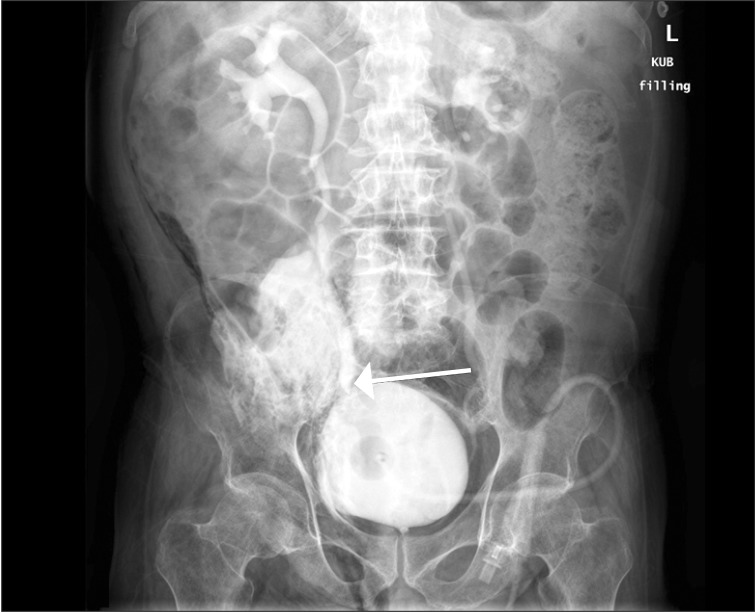

In [1]:
from PIL import Image

Image.open('/cs/labs/tomhope/dhtandguy21/restore_yuvalbus/data2/PMC5256330/5256330_1/5256330_1_3.jpg')

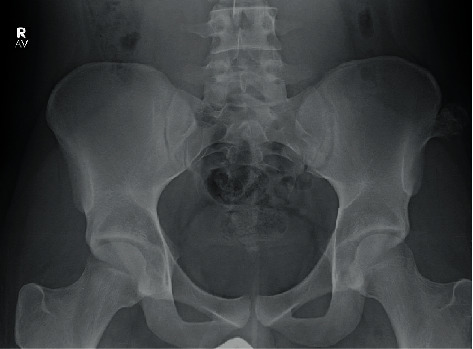

In [95]:
Image.open('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC7762652/7762652_1/7762652_1_1.jpg')

In [96]:
# os.makedirs("largeLists")

In [89]:
with open("largeListsGuy/visual_labeled_img_negative_pairs.pkl", "wb") as g:
    pickle.dump(visual_labeled_img_negative_pairs, g)

In [98]:
# END of Creating hard negatives from high visual similarity, based on patients not similar to any other patient

In [90]:
# Combining pos and neg image-pairs
# labeled_img_pairs = labeled_img_positive_pairs + labeled_img_negative_pairs
labeled_img_pairs = labeled_img_positive_pairs

In [91]:
len(labeled_img_pairs)

1321

In [92]:
with open("largeListsGuy/retrieval_labeled_img_pairs.pkl", "wb") as f:
    pickle.dump(labeled_img_pairs, f)

In [93]:
with open("largeListsGuy/retrieval_labeled_img_pairs.pkl", "rb") as f:
    labeled_img_pairs = pickle.load(f)

In [94]:
len(labeled_img_pairs)

1321

In [787]:
# Calculating two textual embedddings
txt_path_0 = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_5.txt'
txt_path_1 = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5563556/5563556_1/5563556_1_4.txt'

# Open and read the text files
with open(txt_path_0, 'r') as f:
    caption_0 = f.read().strip()  # Read and strip any whitespace or newline characters

with open(txt_path_1, 'r') as f:
    caption_1 = f.read().strip()

# Tokenize the captions using BioMedCLIP's tokenizer
tokens_0 = tokenizer(caption_0).to(device)
tokens_1 = tokenizer(caption_1).to(device)

# Compute text embeddings without gradient computation
with torch.no_grad():
    text_ftrs_0 = biomedclip_model.encode_text(tokens_0)
    text_ftrs_1 = biomedclip_model.encode_text(tokens_1)

# Compute cosine similarity
cos_sim = torch.nn.functional.cosine_similarity(text_ftrs_0, text_ftrs_1)
print(f"Cosine Similarity: {cos_sim.item()}")


Cosine Similarity: 0.7043734788894653


In [788]:
labeled_img_pairs[0:2] + labeled_img_pairs[7773:7775]

[(('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_2.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5563556/5563556_1/5563556_1_3.jpg'),
  1),
 (('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC8167975/8167975_1/8167975_1_8.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5563556/5563556_1/5563556_1_4.jpg'),
  1),
 (('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3660158/3660158_1/3660158_1_5.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4774301/4774301_1/4774301_1_5.jpg'),
  0),
 (('/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3660158/3660158_1/3660158_1_6.jpg',
   '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4774301/4774301_1/4774301_1_5.jpg'),
  0)]

In [87]:
img_positive_pairs[5][0].split('/')

['',
 'cs',
 'labs',
 'tomhope',
 'yuvalbus',
 'pmc',
 'pythonProject',
 'data2',
 'PMC7529124',
 '7529124_1',
 '7529124_1_1.jpg']